# 1. Standard Convolution
Standard convolution applies C_out filters of size k×k×C_in across an image.

For input shape (H, W, C_in), output shape becomes:

H_out = (H - k + 2p) / s + 1  
W_out = (W - k + 2p) / s + 1

Parameters = k × k × C_in × C_out  
FLOPs ≈ H_out × W_out × k × k × C_in × C_out  


In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader




In [5]:
# simple convolution demonstration
conv = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3)
input_tensor = torch.randn(1, 3, 32, 32)
output = conv(input_tensor)
output.shape

torch.Size([1, 4, 30, 30])

# 2. Different Types of Convolution
We demonstrate:
- Standard Convolution  
- Group Convolution  
- Depthwise Convolution  
- Pointwise Convolution (1×1 Conv)


In [2]:
# Standard Convolution
std = nn.Conv2d(16, 32, kernel_size=3)

# Group Convolution (two groups)
grp = nn.Conv2d(16, 32, kernel_size=3, groups=2)

# Depthwise Convolution: groups = in_channels
depth = nn.Conv2d(16, 16, kernel_size=3, groups=16)

# Pointwise Convolution (1x1)
point = nn.Conv2d(16, 32, kernel_size=1)

print("Standard Conv params:", sum(p.numel() for p in std.parameters()))
print("Group Conv params:", sum(p.numel() for p in grp.parameters()))
print("Depthwise Conv params:", sum(p.numel() for p in depth.parameters()))
print("Pointwise Conv params:", sum(p.numel() for p in point.parameters()))


Standard Conv params: 4640
Group Conv params: 2336
Depthwise Conv params: 160
Pointwise Conv params: 544


In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


Device: cpu


In [7]:
class CNN_Standard(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # Standard
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [8]:
class CNN_Group(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, groups=1)  # groups=1 is normal
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, groups=2)  # Grouped convolution
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [9]:
class CNN_Depthwise(nn.Module):
    def __init__(self):
        super().__init__()
        self.depth = nn.Conv2d(1, 1, 3, padding=1, groups=1)  # still single channel
        self.point = nn.Conv2d(1, 16, 1)                      # mix channels
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = F.relu(self.depth(x))
        x = F.relu(self.point(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [10]:
class CNN_Pointwise(nn.Module):
    def __init__(self):
        super().__init__()
        self.pw1 = nn.Conv2d(1, 16, 1)       # 1×1 conv only
        self.pw2 = nn.Conv2d(16, 32, 1)
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = F.relu(self.pw1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.pw2(x))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [11]:
def train_and_eval(model, name, epochs=3):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print(f"\nTraining {name} Model...\n")
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        print(f"Epoch {epoch+1} Train Accuracy: {correct/total:.4f}")

    # evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

    print(f"{name} Test Accuracy: {correct/total:.4f}")
    return correct/total


In [12]:
acc_std = train_and_eval(CNN_Standard(), "Standard")
acc_grp = train_and_eval(CNN_Group(), "Group")
acc_depth = train_and_eval(CNN_Depthwise(), "Depthwise")
acc_point = train_and_eval(CNN_Pointwise(), "Pointwise")

print("\n--- Final Accuracy Comparison ---")
print("Standard   :", acc_std)
print("Group      :", acc_grp)
print("Depthwise  :", acc_depth)
print("Pointwise  :", acc_point)



Training Standard Model...

Epoch 1 Train Accuracy: 0.9297
Epoch 2 Train Accuracy: 0.9799
Epoch 3 Train Accuracy: 0.9846
Standard Test Accuracy: 0.9866

Training Group Model...

Epoch 1 Train Accuracy: 0.9217
Epoch 2 Train Accuracy: 0.9764
Epoch 3 Train Accuracy: 0.9825
Group Test Accuracy: 0.9834

Training Depthwise Model...

Epoch 1 Train Accuracy: 0.8979
Epoch 2 Train Accuracy: 0.9681
Epoch 3 Train Accuracy: 0.9759
Depthwise Test Accuracy: 0.9806

Training Pointwise Model...

Epoch 1 Train Accuracy: 0.8214
Epoch 2 Train Accuracy: 0.8762
Epoch 3 Train Accuracy: 0.8882
Pointwise Test Accuracy: 0.8906

--- Final Accuracy Comparison ---
Standard   : 0.9866
Group      : 0.9834
Depthwise  : 0.9806
Pointwise  : 0.8906


# 3. Receptive Fields
Receptive field tells how much of the input influences each output unit.

Examples:
- One 3×3 kernel → RF = 3  
- Two stacked 3×3 kernels → RF = 5  
- Three stacked 3×3 kernels → RF = 7

General formula for stacked k×k convs (stride 1):
RF_L = 1 + (k - 1)L  


In [14]:
def receptive_field(layers, k=3):
    return 1 + (k - 1) * layers

for L in [1, 2, 3]:
    print(f"{L} stacked 3×3 gives RF =", receptive_field(L))


1 stacked 3×3 gives RF = 3
2 stacked 3×3 gives RF = 5
3 stacked 3×3 gives RF = 7


# 4. Demonstrating that stacked 3×3 approximates 5×5 and 7×7
We will visualize the effect of:
- Single 5×5 Conv  
- Single 7×7 Conv  
- Stacked 3×3 Conv (2 layers and 3 layers)

We create simple filters to show how the effective receptive field grows.


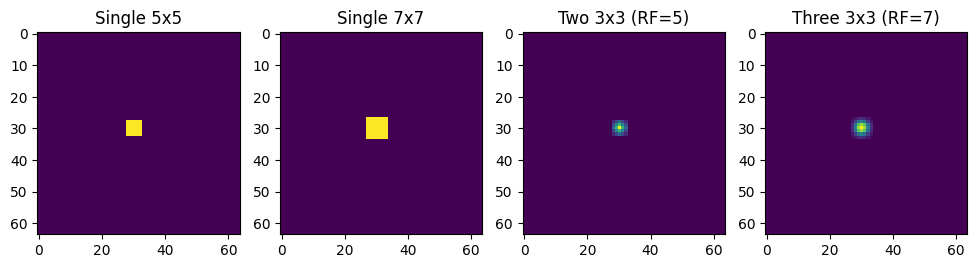

In [15]:
import cv2

# simple synthetic image
img = np.zeros((64,64), dtype=np.float32)
img[30,30] = 1.0  # impulse for visualization

# helper to apply conv
def apply_conv(img, k):
    f = np.ones((k,k), dtype=np.float32) / (k*k)
    return cv2.filter2D(img, -1, f)

res_5 = apply_conv(img, 5)
res_7 = apply_conv(img, 7)

# stacked 3x3
intermediate = apply_conv(img, 3)
res_33 = apply_conv(intermediate, 3)

intermediate2 = res_33.copy()
res_333 = apply_conv(intermediate2, 3)

plt.figure(figsize=(12,6))
plt.subplot(1,4,1); plt.imshow(res_5); plt.title("Single 5x5")
plt.subplot(1,4,2); plt.imshow(res_7); plt.title("Single 7x7")
plt.subplot(1,4,3); plt.imshow(res_33); plt.title("Two 3x3 (RF=5)")
plt.subplot(1,4,4); plt.imshow(res_333); plt.title("Three 3x3 (RF=7)")
plt.show()


# 5. Parameter and FLOPs Comparison
Compare:
1. Single 5×5 conv  
2. Two stacked 3×3 convs  
3. Three stacked 3×3 convs  

We calculate parameter savings.


In [16]:
def conv_params(k, c_in=64, c_out=64):
    return k*k*c_in*c_out

print("5×5 Conv params:", conv_params(5))
print("Two 3×3 params:", conv_params(3)*2)
print("Three 3×3 params:", conv_params(3)*3)

print("\n5×5 params / two 3×3 params ratio:", conv_params(5)/(2*conv_params(3)))
print("5×5 params / three 3×3 params ratio:", conv_params(5)/(3*conv_params(3)))


5×5 Conv params: 102400
Two 3×3 params: 73728
Three 3×3 params: 110592

5×5 params / two 3×3 params ratio: 1.3888888888888888
5×5 params / three 3×3 params ratio: 0.9259259259259259


# 6. Residual Connections
Residual block:  
y = F(x) + x  

Advantages:
- Helps gradient propagation  
- Prevents degradation in very deep nets  
- Used in ResNet and Inception-ResNet


In [17]:
class PlainCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = torch.relu(out)
        out = self.conv2(out)
        return torch.relu(out + x)

x = torch.randn(1, 64, 32, 32)
block = ResidualBlock(64)
y = block(x)
y.shape


torch.Size([1, 64, 32, 32])

In [19]:
class ResidualCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_in = nn.Conv2d(1, 32, 3, padding=1)
        self.res1 = ResidualBlock(32)
        self.res2 = ResidualBlock(32)
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = F.relu(self.conv_in(x))
        x = self.res1(x)
        x = F.max_pool2d(x, 2)
        x = self.res2(x)
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [20]:
loss_plain = train_and_eval(PlainCNN(), "Plain CNN")
loss_res = train_and_eval(ResidualCNN(), "Residual CNN")



Training Plain CNN Model...

Epoch 1 Train Accuracy: 0.9414
Epoch 2 Train Accuracy: 0.9836
Epoch 3 Train Accuracy: 0.9883
Plain CNN Test Accuracy: 0.9897

Training Residual CNN Model...

Epoch 1 Train Accuracy: 0.9521
Epoch 2 Train Accuracy: 0.9862
Epoch 3 Train Accuracy: 0.9895
Residual CNN Test Accuracy: 0.9911


In [21]:
features_plain = {}
features_res = {}

def hook_fn(storage):
    def hook(module, input, output):
        storage['feat'] = output.detach().cpu()
    return hook


In [22]:
plain_model = PlainCNN().to(device)
res_model = ResidualCNN().to(device)

plain_model.conv1.register_forward_hook(hook_fn(features_plain))
res_model.conv_in.register_forward_hook(hook_fn(features_res))


In [23]:
img, _ = test_dataset[0]
img = img.unsqueeze(0).to(device)

_ = plain_model(img)
_ = res_model(img)


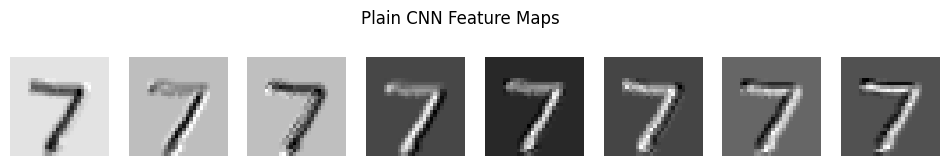

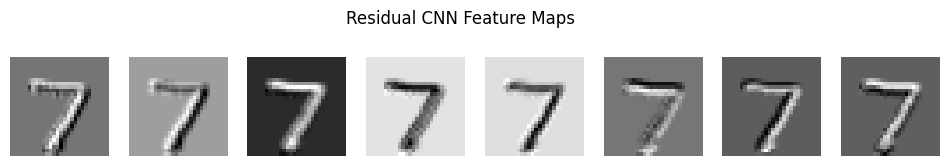

In [24]:
def show_features(feat, title):
    fmap = feat['feat'][0][:8]  # first 8 channels
    fig, axes = plt.subplots(1, 8, figsize=(12,2))
    for i in range(8):
        axes[i].imshow(fmap[i], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

show_features(features_plain, "Plain CNN Feature Maps")
show_features(features_res, "Residual CNN Feature Maps")


# 7. Inception Block
Inception uses multiple branches:
- 1×1 conv
- 3×3 conv
- 5×5 conv (or 2×3×3)
- Max pool + 1×1 conv

Outputs are concatenated along the channel dimension.


In [28]:
class InceptionBlock(nn.Module):
    def __init__(self, in_ch, c1, c3r, c3, c5r, c5, pool_proj):
        super().__init__()

        self.branch1 = nn.Conv2d(in_ch, c1, kernel_size=1)

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_ch, c3r, kernel_size=1),
            nn.Conv2d(c3r, c3, kernel_size=3, padding=1)
        )

        self.branch5 = nn.Sequential(
            nn.Conv2d(in_ch, c5r, kernel_size=1),
            nn.Conv2d(c5r, c5, kernel_size=5, padding=2)
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_ch, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch3(x),
            self.branch5(x),
            self.branch_pool(x)
        ], dim=1)


In [29]:
class InceptionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Conv2d(1, 32, 3, padding=1)

        self.incept1 = InceptionBlock(32, 16, 16, 24, 8, 8, 8)

        self.pool = nn.MaxPool2d(2)

        self.fc = nn.Linear(56 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.stem(x))
        x = self.incept1(x)
        x = self.pool(x)
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [30]:
# plain_model = PlainCNN()
incept_model = InceptionCNN()

# loss_plain = train_and_eval(plain_model, "Plain CNN")
loss_incept = train_and_eval(incept_model, "Inception Net")



Training Inception Net Model...

Epoch 1 Train Accuracy: 0.9388
Epoch 2 Train Accuracy: 0.9822
Epoch 3 Train Accuracy: 0.9853
Inception Net Test Accuracy: 0.9837
